# Homework 7: Classification

## The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, puctuation, etc. of written sentences.
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

This homework assignment is very similar to the in-class lab exercise that you completed this week.


The dataset is from the "Malicious and Benign Websites" Kaggle project at https://www.kaggle.com/xwolf12/malicious-and-benign-websites/home (you'll need to go to that URL to get a full description of the data).

From the overview:

The project consisted to evaluate different classification models to predict malicious and benign websites, based on application layer and network characteristics. The data were obtained by using different verified sources of benign and malicious URL's, in a low interactive client honeypot to isolate network traffic. We used additional tools to get other information, such as, server country with Whois.

Your task is to build the best classifier you can, choosing from either Random Forests or Naive Bayes classifiers (i.e. no XGBoost, SVM, Logistic Regression, etc.).

You will need to split the complete dataset into training and testing datasets.  We recommend a 70%-30% split.

1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.  Be sure to provide interpretations of your results.

2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points). Be sure to provide interpretations of your results.

3. Tune your Random Forest model by varying hyperparamters (15 points). Be sure to provide interpretations of your results.

3. Experiment with setting the appropriate values for *priors* in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points). Be sure to provide interpretations of your results.

4. Report the most important feature(s) based on your Random Forest classifier (10 points). Are you surprised by the results?  Explain why.

5. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results.  You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)


In [215]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.ensemble as skens
import sklearn.metrics as skmetric
import sklearn.naive_bayes as sknb
import sklearn.tree as sktree
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)
import sklearn.externals.six as sksix
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import os


In [216]:
data = pd.read_csv('malicious-and-benign-websites.csv')

In [217]:
data.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,...,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,None,None,10/10/2015 18:21,None,...,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,None,None,None,None,...,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,None,None,None,None,...,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,...,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,None,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,...,2,5,4278,61,62,129889,4586,61,4.0,0


In [218]:
# find string columns 
colStr = data.dtypes[data.dtypes== 'object']

# count the 'None' for every columns
colStr = data.dtypes[data.dtypes== 'object']
calNone = {col: len(data[data.loc[:,col]=='None']) for col in colStr.index}
calNone

{'URL': 0,
 'CHARSET': 7,
 'SERVER': 175,
 'WHOIS_COUNTRY': 306,
 'WHOIS_STATEPRO': 362,
 'WHOIS_REGDATE': 127,
 'WHOIS_UPDATED_DATE': 139}

In [219]:
# count the unique for every columns
calUni = {col:len(data.loc[:,col].unique()) for col in data.columns}
calUni

{'URL': 1781,
 'URL_LENGTH': 142,
 'NUMBER_SPECIAL_CHARACTERS': 31,
 'CHARSET': 9,
 'SERVER': 240,
 'CONTENT_LENGTH': 638,
 'WHOIS_COUNTRY': 49,
 'WHOIS_STATEPRO': 182,
 'WHOIS_REGDATE': 891,
 'WHOIS_UPDATED_DATE': 594,
 'TCP_CONVERSATION_EXCHANGE': 103,
 'DIST_REMOTE_TCP_PORT': 66,
 'REMOTE_IPS': 18,
 'APP_BYTES': 825,
 'SOURCE_APP_PACKETS': 113,
 'REMOTE_APP_PACKETS': 116,
 'SOURCE_APP_BYTES': 885,
 'REMOTE_APP_BYTES': 822,
 'APP_PACKETS': 113,
 'DNS_QUERY_TIMES': 11,
 'Type': 2}

In [220]:
# find columns that are totaally different and cannot used as the categoriable variables
uniqueVal = ['URL','WHOIS_REGDATE','WHOIS_UPDATED_DATE','CONTENT_LENGTH']
data.loc[:,uniqueVal].head() 

,URL,WHOIS_REGDATE,WHOIS_UPDATED_DATE,CONTENT_LENGTH
0,M0_109,10/10/2015 18:21,None,263.0
1,B0_2314,None,None,15087.0
2,B0_911,None,None,324.0
3,B0_113,7/10/1997 4:00,12/09/2013 0:45,162.0
4,B0_403,12/05/1996 0:00,11/04/2017 0:00,124140.0


In [221]:
data_dropUniq = data.drop(columns=uniqueVal)
nansum = pd.DataFrame(data_dropUniq.isna().sum()).sort_values(by=0, ascending = False)
nansum.head()

,0
DNS_QUERY_TIMES,1
SERVER,1
URL_LENGTH,0
APP_BYTES,0
APP_PACKETS,0


In [222]:
# drop nan
data_final_dropna = data_dropUniq.dropna() # drop all rows with nan
len(data_final_dropna)

1779

In [223]:
# tanfer dummies variables into list of different categories
data_final_dum = pd.get_dummies(data_final_dropna)
print(data_final_dum.shape)
data_final_dum.head()

(1779, 491)


,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,...,WHOIS_STATEPRO_kireka,WHOIS_STATEPRO_liaoningsheng,WHOIS_STATEPRO_nj,WHOIS_STATEPRO_ny,WHOIS_STATEPRO_qc,WHOIS_STATEPRO_quebec,WHOIS_STATEPRO_shandong,WHOIS_STATEPRO_va,WHOIS_STATEPRO_widestep@mail.ru,WHOIS_STATEPRO_worcs
0,16,7,7,0,2,700,9,10,1153,832,...,0,0,0,0,0,0,0,0,0,0
1,16,6,17,7,4,1230,17,19,1265,1230,...,0,0,0,0,0,0,0,0,0,0
2,16,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,17,6,31,22,3,3812,39,37,18784,4380,...,0,0,0,0,0,0,0,0,0,0
4,17,6,57,2,5,4278,61,62,129889,4586,...,0,0,0,0,0,0,0,0,0,0


In [224]:
listcol = data_final_dum.columns
listcol[350:400]

Index(['WHOIS_STATEPRO_Greater London', 'WHOIS_STATEPRO_HANTS',
       'WHOIS_STATEPRO_HR', 'WHOIS_STATEPRO_Haryana', 'WHOIS_STATEPRO_IL',
       'WHOIS_STATEPRO_ILOCOS NORTE R3', 'WHOIS_STATEPRO_INDAL',
       'WHOIS_STATEPRO_Illinois', 'WHOIS_STATEPRO_Indiana',
       'WHOIS_STATEPRO_KG', 'WHOIS_STATEPRO_KS', 'WHOIS_STATEPRO_Kansas',
       'WHOIS_STATEPRO_Karnataka', 'WHOIS_STATEPRO_Kentucky',
       'WHOIS_STATEPRO_Krasnoyarsk', 'WHOIS_STATEPRO_LA',
       'WHOIS_STATEPRO_London', 'WHOIS_STATEPRO_MA',
       'WHOIS_STATEPRO_MAHARASHTR', 'WHOIS_STATEPRO_MAINE',
       'WHOIS_STATEPRO_MB', 'WHOIS_STATEPRO_MD', 'WHOIS_STATEPRO_ME',
       'WHOIS_STATEPRO_MH', 'WHOIS_STATEPRO_MI', 'WHOIS_STATEPRO_MIDDLESEX',
       'WHOIS_STATEPRO_MO', 'WHOIS_STATEPRO_MOSCOW',
       'WHOIS_STATEPRO_Maharashtra', 'WHOIS_STATEPRO_Mahe',
       'WHOIS_STATEPRO_Maine', 'WHOIS_STATEPRO_Manila',
       'WHOIS_STATEPRO_Manitoba', 'WHOIS_STATEPRO_Maryland',
       'WHOIS_STATEPRO_Massachusetts', 'WHOIS_STATEP

### 1. Build both Random Forest (10 points) and Naive Bayes (10 points) classifiers to predict the TYPE variable.  Be sure to provide interpretations of your results.

In [225]:
df_web_train,df_web_test = train_test_split(data_final_dum, test_size=0.3)

In [226]:
# build a random forest

df_web_train_dropY = df_web_train.loc[:, df_web_train.columns != 'Type']
df_web_test_dropY = df_web_test.loc[:, df_web_test.columns != 'Type']

# df_web_train_dropY = df_web_train.iloc[:,:len(df_web_train.columns)-1]
# df_web_test_dropY = df_web_test.iloc[:,:len(df_web_train.columns)-1]

rf_model = skens.RandomForestClassifier(n_estimators=10, oob_score=False, criterion='entropy')
# oob_score: whether to use out-of-bag samples to estimate the R^2 on unseen data.
rf_model.fit(df_web_train_dropY,df_web_train.Type)

# this is testing the model 
predicted_labels = rf_model.predict(df_web_test_dropY)
df_web_test['predicted_rf_tree'] = predicted_labels

/anaconda2/envs/mypython/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


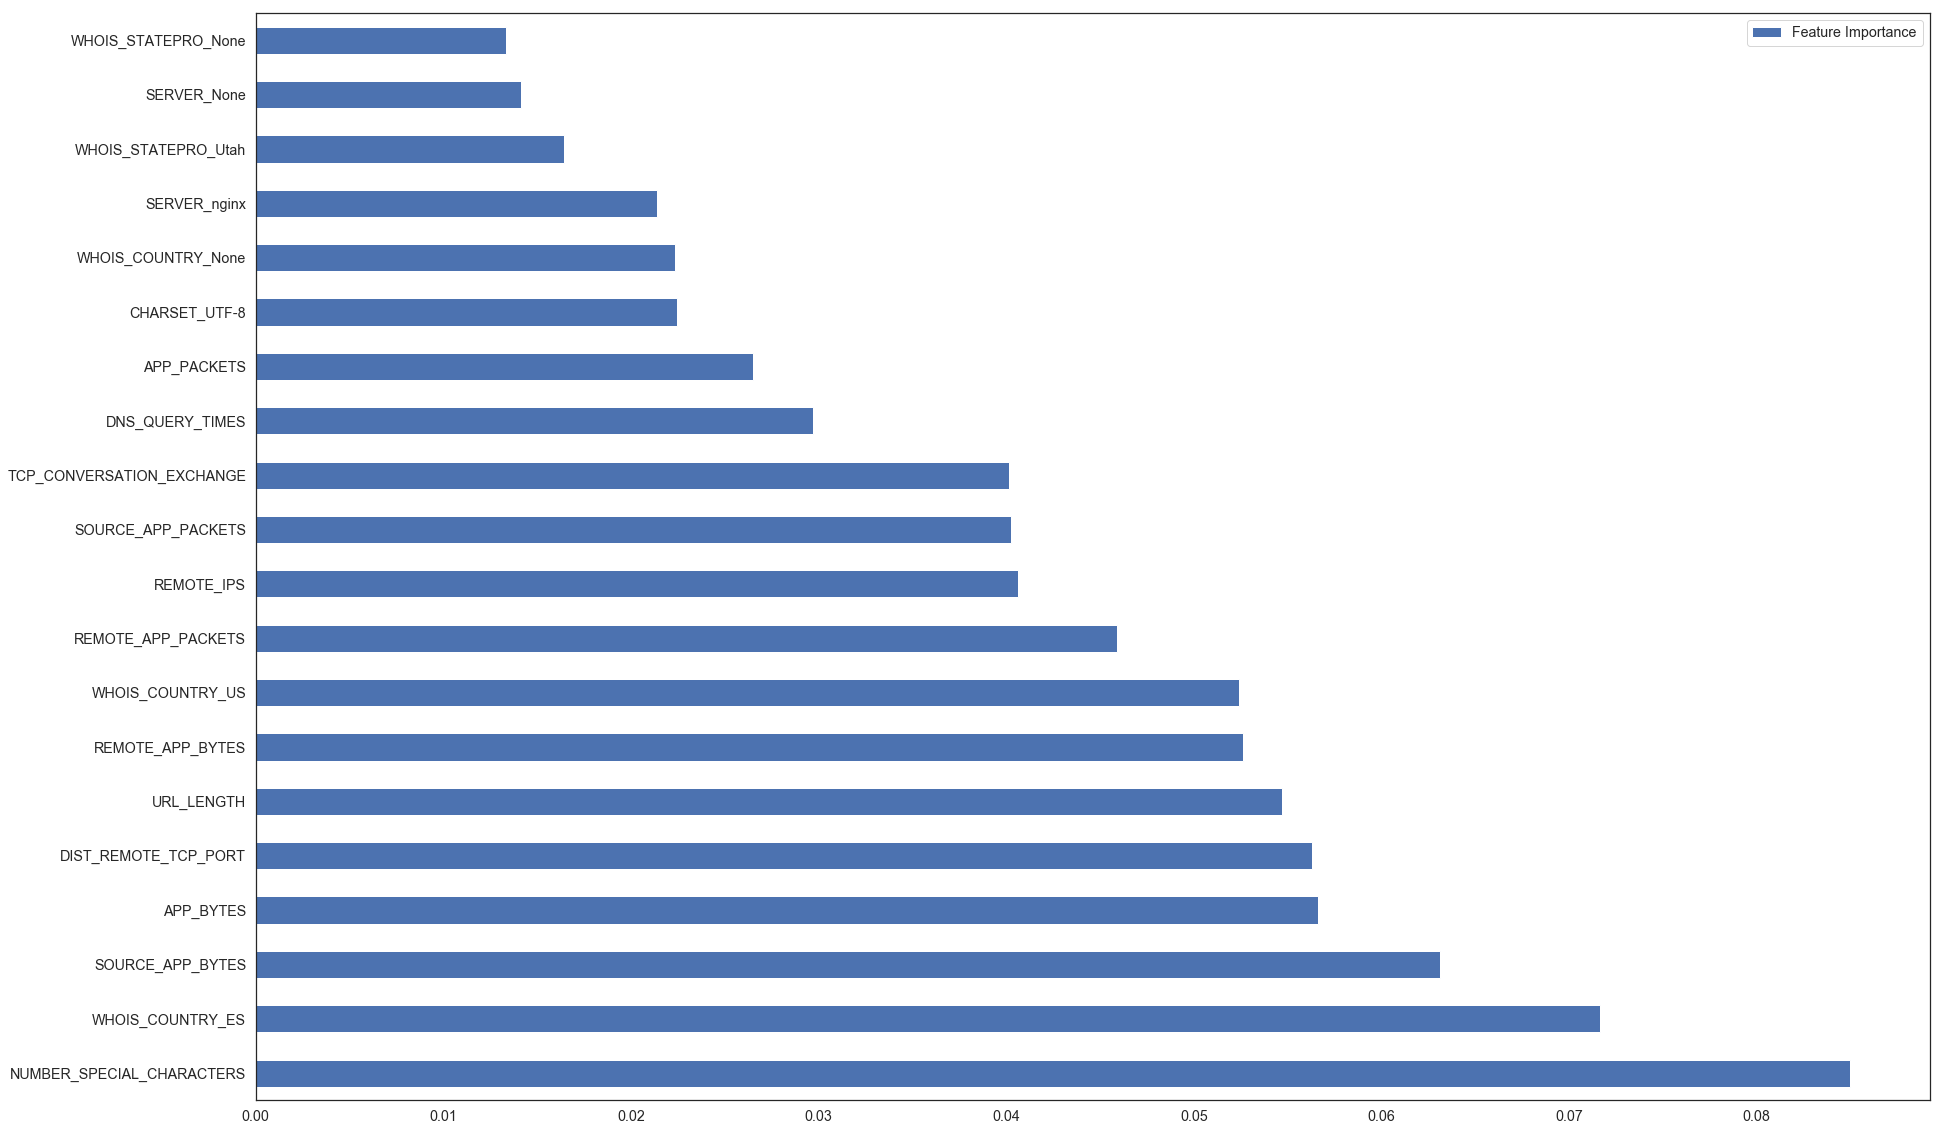

In [227]:
# Check feature importance with biggest 20 features
feat_importance = rf_model.feature_importances_
biggest = pd.DataFrame({'Feature Importance':feat_importance},index=df_web_test_dropY.columns).sort_values(by='Feature Importance', ascending=False)
biggest[:20].plot(kind='barh', figsize=(30,20))

In [228]:
# # get model score for RF
# rf_model.fit(df_web_train_dropY,df_web_train.Type)
# print(rf_model.score(df_web_test_dropY, df_web_test.Type))

# anotehr way : using cv， assumed parameters
from sklearn.model_selection import GridSearchCV
params = {
                 'n_estimators': [5],
                 'max_depth': [2],
            }
RF_CV = GridSearchCV(rf_model, cv=10, param_grid=params, iid = True)
RF_CV.fit(df_web_train_dropY,df_web_train.Type)
print(RF_CV.cv_results_['mean_test_score'])

[0.8875502]


### 1.2 Naive Bayes (10 points) classifiers to predict the TYPE variable

In [229]:
# train the model by Naive Bayes
gnb_model = sknb.GaussianNB()
# given sepal length, predict if setosa
gnb_model.fit(df_web_train_dropY,df_web_train.Type)

GaussianNB(priors=None, var_smoothing=1e-09)

In [230]:
# test the model
df_web_testNB = df_web_test.copy()
y_pred = gnb_model.predict(df_web_test_dropY)
df_web_testNB['predicted_nb'] = y_pred
# comparePlot(df_web_testNB,"Type","predicted_nb")

In [231]:
# get model score for NB
# gnb_model.fit(df_web_train_dropY,df_web_train.Type)
# print(gnb_model.score(df_web_test_dropY, df_web_test.Type))

# another way
# cal cv errors for NB 
params = {}
NB_CV = GridSearchCV(gnb_model, cv=10, param_grid=params, iid = True)
NB_CV.fit(df_web_train_dropY,df_web_train.Type)
print(NB_CV.cv_results_['mean_test_score'])

[0.24899598]


As the column "CONTENT_LENGTH" has too much NaN, it is dropped and dropna was used for dropping nan in different rows. From the Random Forest, the top 20 influential features was plotted above. Random Forest model was built and its CV erros with 10 folders was about 88% accuracy, but Naive Bayes only has 38% accuracy. 

### 2. Experiment with changing the number of "folds" in your cross-validator for your Random Forest classifiers (10 points). Be sure to provide interpretations of your results.

In [252]:
# Model Selection and Comparison
from sklearn.model_selection import GridSearchCV
param_grid = {} # fixex param for all cv situations
cv_grid = [10, 100, 200]

grid_clf = GridSearchCV(rf_model, param_grid, cv=cv_grid[0])
grid_clf.fit(df_web_train_dropY,df_web_train.Type)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [253]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [254]:
grid_clf.cv_results_['mean_test_score']

array([0.95180723])

In [255]:
# for another cv condition cv = 100
grid_clf = GridSearchCV(rf_model, param_grid, cv=cv_grid[1])
grid_clf.fit(df_web_train_dropY,df_web_train.Type)
print(grid_clf.best_estimator_)
print(grid_clf.cv_results_['mean_test_score'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[0.95582329]


/anaconda2/envs/mypython/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [256]:
# for another cv condition cv = 15
grid_clf = GridSearchCV(rf_model, param_grid, cv=cv_grid[2])
grid_clf.fit(df_web_train_dropY,df_web_train.Type)
print(grid_clf.best_estimator_)
print(grid_clf.cv_results_['mean_test_score'])

/anaconda2/envs/mypython/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 148 members, which is too few. The minimum number of members in any class cannot be less than n_splits=200.
  % (min_groups, self.n_splits)), Warning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[0.95742972]


/anaconda2/envs/mypython/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fixed Parameters, with different value of folds for CV methdo, the accuracies incrase a little, while still are closed to each other, 

### 3. Tune your Random Forest model by varying hyperparamters (15 points). Be sure to provide interpretations of your results.


In [237]:
# Model Selection and Comparison
param_grid = {
                 'n_estimators': [5, 10, 15, 20, 25],
                 'max_depth': [2, 5, 7, 9],
             }
grid_clf = GridSearchCV(rf_model, param_grid, cv=10)
grid_clf.fit(df_web_train_dropY,df_web_train.Type)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [2, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [238]:
grid_clf.best_params_

{'max_depth': 9, 'n_estimators': 5}

In [239]:
grid_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [240]:
grid_clf.cv_results_['mean_test_score']

array([0.89076305, 0.88353414, 0.88514056, 0.88273092, 0.8811245 ,
       0.90763052, 0.91084337, 0.90843373, 0.91084337, 0.91164659,
       0.92048193, 0.91967871, 0.9188755 , 0.91566265, 0.91646586,
       0.93815261, 0.93413655, 0.93493976, 0.92851406, 0.93413655])

In [241]:
grid_clf.cv_results_['mean_test_score'].max()

0.9381526104417671

With differet hyperparamters: n_estimators, max_depth, the best model has parameters {'max_depth': 9, 'n_estimators': 10}, and its highest average accuracy is 93.97% under 10 folder CV.

### 4. Experiment with setting the appropriate values for priors in the Naive Bayes model (the priors should correspond to the proportions of the TYPE values) (10 points). Be sure to provide interpretations of your results.


In [242]:
gnb_model.class_prior_

array([0.8811245, 0.1188755])

In [243]:
# cal the percent of zero in train dataset
len(df_web_train[df_web_train.Type == 0])/len(df_web_train)

0.8811244979919679

In [244]:
# assume prior is half half
gnb_model_newPr = sknb.GaussianNB(priors=[0.5, 0.5])

In [245]:
# cal cv errors for NB 
params = {}
NB_CV_new = GridSearchCV(gnb_model_newPr, cv=10, param_grid=params, iid = True) # 
NB_CV_new.fit(df_web_train_dropY,df_web_train.Type)
print(NB_CV_new.cv_results_['mean_test_score'])

# another way:
# get model score
# gnb_model_newPr.fit(df_web_train_dropY,df_web_train.Type)
# gnb_model_newPr.score(df_web_test_dropY, df_web_test.Type)

[0.23614458]


From the calculateion of zero in TYPE, we foundt the original NB model uses the prior in dataset. If we assume both 0 and 1 has 50% prior, with same CV method, accuracy of NB method is reduved from 38% to 35%, supporting the importance of suitable prior choice.

### 5. Report the most important feature(s) based on your Random Forest classifier (10 points). Are you surprised by the results? Explain why.


In [246]:
# from q2, we find the optimal RF model
OptRF_model = grid_clf.best_estimator_

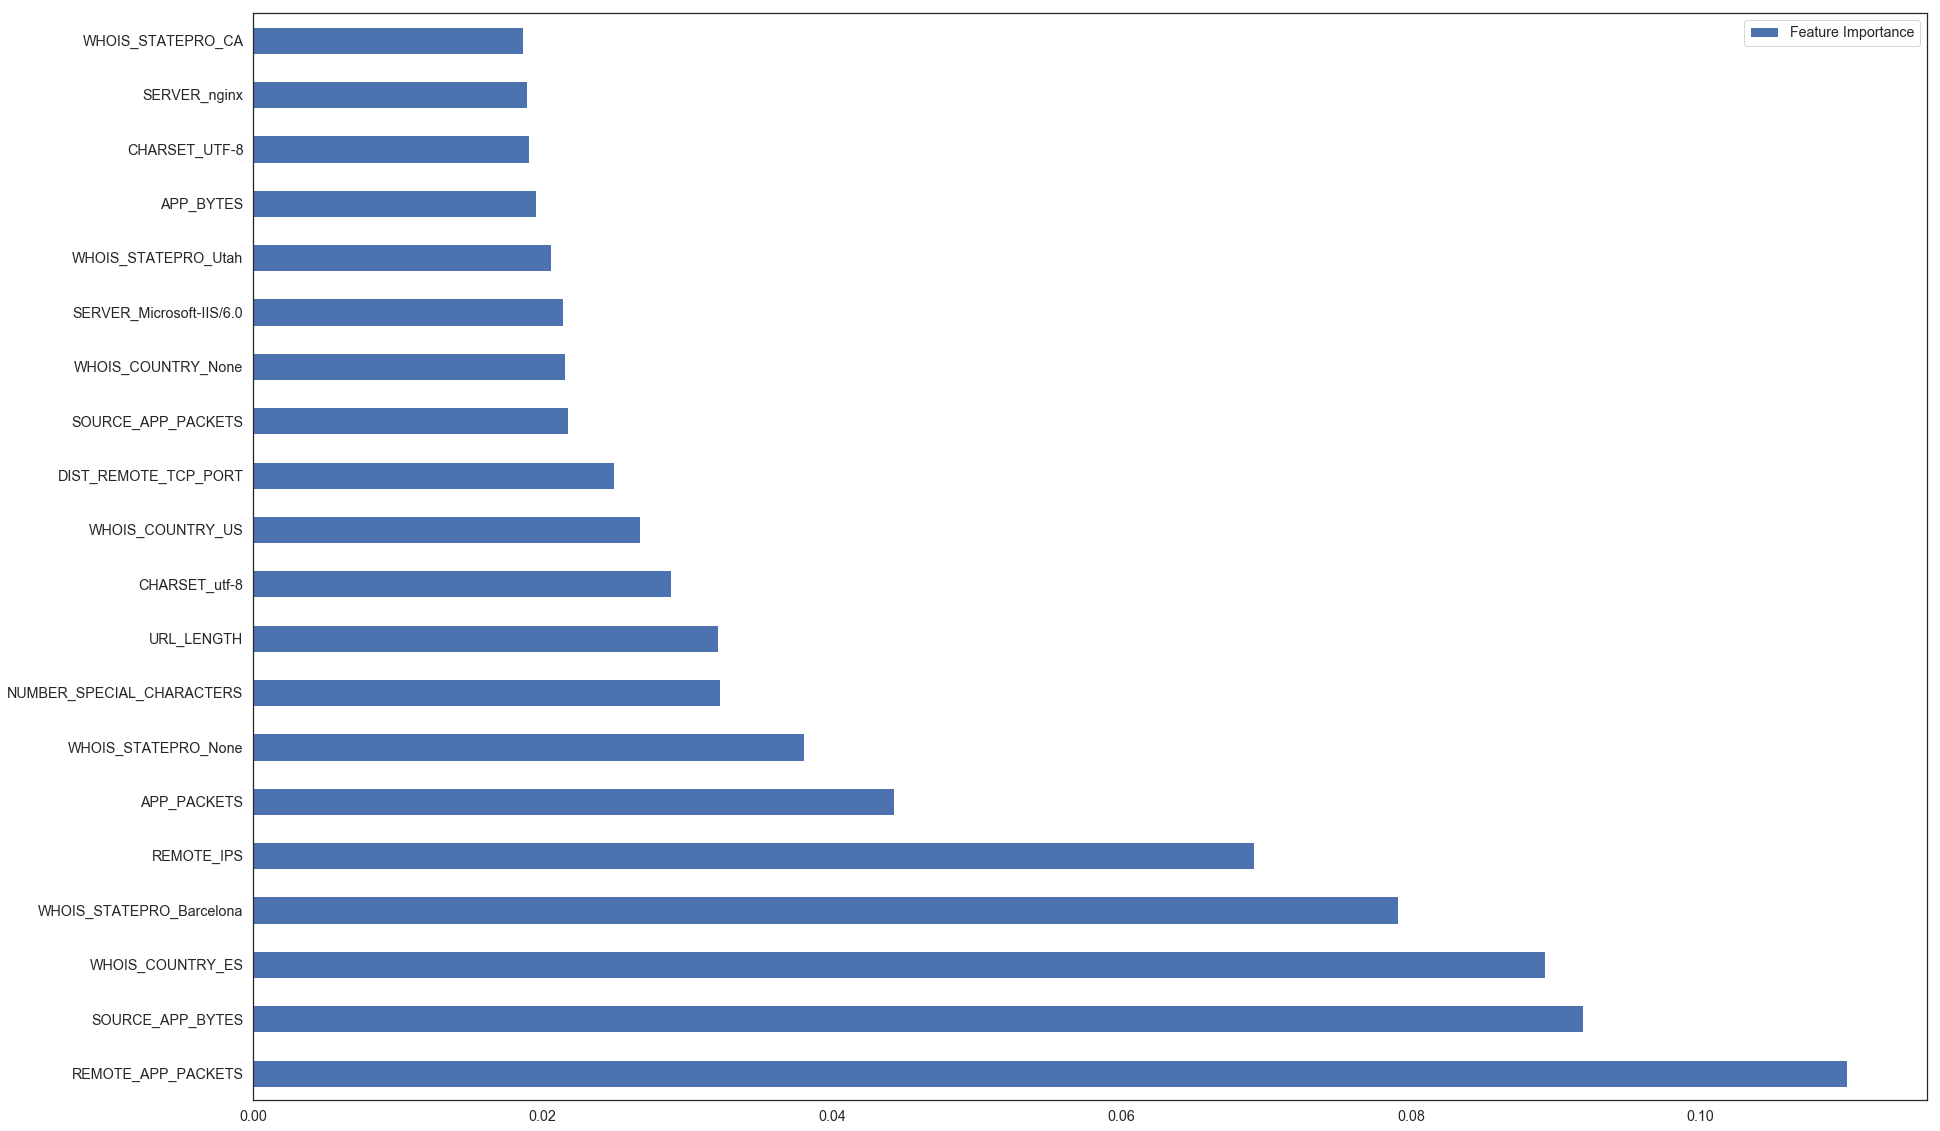

In [247]:
# Check feature importance with biggest 20 features
feat_importance = OptRF_model.feature_importances_
biggest_opt = pd.DataFrame({'Feature Importance':feat_importance},index=df_web_test_dropY.columns).sort_values(by='Feature Importance', ascending=False)
biggest_opt[:20].plot(kind='barh', figsize=(30,20))

In [248]:
# biggest is sorted features from original rf model; biggest_opt is sorted features from new model
pd.merge(biggest[:20].reset_index(), biggest_opt[:20].reset_index(), on='index', how= 'outer')

,index,Feature Importance_x,Feature Importance_y
0,NUMBER_SPECIAL_CHARACTERS,0.084973,0.032292
1,WHOIS_COUNTRY_ES,0.071669,0.089280
2,SOURCE_APP_BYTES,0.063098,0.091900
3,APP_BYTES,0.056615,0.019521
4,DIST_REMOTE_TCP_PORT,0.056325,0.024927
5,URL_LENGTH,0.054701,0.032121
6,REMOTE_APP_BYTES,0.052599,NaN
7,WHOIS_COUNTRY_US,0.052410,0.026756
8,REMOTE_APP_PACKETS,0.045925,0.110138
9,REMOTE_IPS,0.040611,0.069131


It seems there is not much difference between top 20 features from the original RF and optimal RF, as there are only 3 new important top 20 features. Surprising thing for me is that the importantce of same features will change, such as 'REMOTE_APP_PACKETS' increased form 8% to 10%, while 'TCP_CONVERSATION_EXCHANGE' drops from 7% to 3%

### 6. Summarize your findings, including which classifier and paramters gave you the best results and include an in-depth explanation of how you might improve your results. You should also investigate what the different fields mean, so you'll need to do some research about websites and internet protocols! (15 points)

In [249]:
data.describe()

,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CONTENT_LENGTH,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
count,1781.000000,1781.000000,969.000000,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1781.000000,1.781000e+03,1.781000e+03,1781.000000,1780.000000,1781.000000
mean,56.961258,11.111735,11726.927761,16.261089,5.472768,3.060640,2.982339e+03,18.540146,18.746210,1.589255e+04,3.155599e+03,18.540146,2.263483,0.121280
std,27.555586,4.549896,36391.809051,40.500975,21.807327,3.386975,5.605057e+04,41.627173,46.397969,6.986193e+04,5.605378e+04,41.627173,2.930853,0.326544
min,16.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,39.000000,8.000000,324.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
50%,49.000000,10.000000,1853.000000,7.000000,0.000000,2.000000,6.720000e+02,8.000000,9.000000,5.790000e+02,7.350000e+02,8.000000,0.000000,0.000000
75%,68.000000,13.000000,11323.000000,22.000000,5.000000,5.000000,2.328000e+03,26.000000,25.000000,9.806000e+03,2.701000e+03,26.000000,4.000000,0.000000
max,249.000000,43.000000,649263.000000,1194.000000,708.000000,17.000000,2.362906e+06,1198.000000,1284.000000,2.060012e+06,2.362906e+06,1198.000000,20.000000,1.000000


The best model is the has parameters {'max_depth': 9, 'n_estimators': 10}, and its average accuracy is 93.97%. 

Some important feasuters explanation: 
REMOTE_IPS: this variable has the total number of IPs connected to the honeypot
SOURCE_APP_PACKETS: packets sent from the honeypot to the server

So far, we drop several columns with too much differed values, such as columsn:'URL','WHOIS_REGDATE','WHOIS_UPDATED_DATE','CONTENT_LENGTH'. But, for example, WHOIS_REGDATE: Whois provides the server registration date, 'CONTENT_LENGTH' it represents the content size of the HTTP header, which can influence the Type ( 1 is for malicious websites and 0 is for benign websites). 

Therefore, we might divided 'WHOIS_REGDATE' specific dates into years, and categorize the length by several intervasl, such as 0-10000, and so on and so forth. Then, these information can be used for prediction and without too many number of factor levels. 